# 18.085 Image Compression Project
### By Sebastian Lopez-Cot

## Introduction

Of many important applications of Linear Algebra and Signal Processing, image compression is one which impacts our lives every day. Images play a key role in any modern-day electronic device whether it be for sending personal photos from a Thanksgiving vacation to family and friends or recording high definition RGB camera data in autonomous driving and aerospace applications. Compression of images is important in these critical scenareos, especially when storage space is limited, connection throughput is limited, or data transfer speeds must be fast. And yet, we as humans are particular. Throwing away important aspects of an image simply will not do. We hope to hold more images in the same space containing most of the original content of the source picture, and so many engineers and mathematicians over decades have developed strategies for compressing images. In this report, I will explore a famous technique of compression via the discrete cosine transform and some other tricks, which is the most basic form of JPEG compression.

In [2]:
# Install necessary libraries
!python3 -m pip install numpy
!python3 -m pip install scipy
!python3 -m pip install opencv-python
!python3 -m pip install matplotlib
!python3 -m pip install huffman

In [153]:
# Project imports that should be run before anything else
import numpy as np
import numpy.fft
import cv2
from scipy import signal
import scipy.fftpack
import matplotlib.pyplot as plt
import huffman

## Encoding

Before getting into any math, let us discuss basic strategy. We will formulate this problem of image compression as a challenge of encoding and decoding a "message" of information. One can supose that the encoder and the decoder might be two individual people living on opposite ends of the world, with an internet connection. The encoder holds a source image, and the decoder would like to take a look at this image. Abstracting away other internet protocol components, we only expect the encoder and decoder to perform operations to construct and reconstruct a "message". The encoder and decoder must agree upon a strategy to read and write this message. Finally, given an image, the encoder should be able to encode this image as a message which is not only small in size, but also should preserve the important parts of the original image such that when the decoder acts to reconstruct the image from this message, it should appear visually indistinguishable.

Here we present a set of example images that can be toggled via uncommenting/commenting out of image paths. Run the following cell to load this image from the filesystem and plot the image.


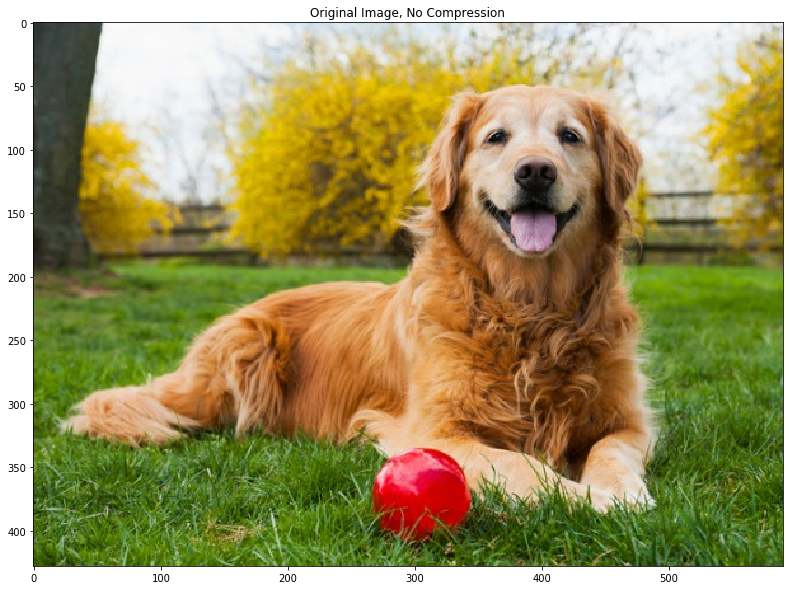

In [154]:
IMG_PATH = "images/dog.jpg"
# IMG_PATH = "images/mit.jpg"
# IMG_PATH = "images/tomcruise.jpg"

# Load in the image in BGR format
raw_img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)

# Plot the image before encoding (in RGB)
plt.rcParams['figure.figsize'] = [15, 10]
rgb = np.fliplr(raw_img.reshape(-1,3)).reshape(raw_img.shape)
plt.title("Original Image, No Compression")
plt.imshow(rgb)

### RGB to YCbCr

The first step in typical JPEG compression is to remove some information about color in order to reduce message size. While it is usual for computers to represent images in the RGB, or red-blue-green, color space, we will convert this image to the YCbCr color space. The structure of a YCbCr image is more conducive to message size reduction because the majority of pixel intensity information is stored in a single channel whereas it is distributed among all three channels in RGB. Below, we visualize the three color channels in YCbCr.

Text(0.5, 1.0, 'Cr (Red shift)')

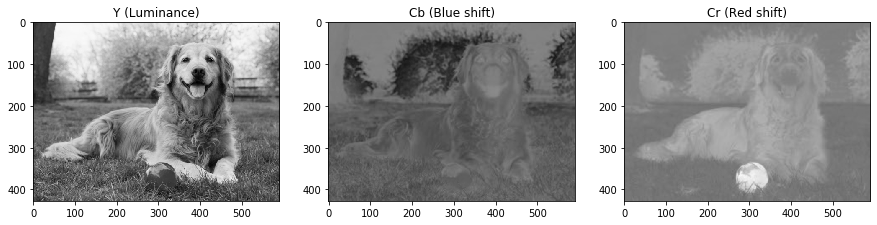

In [155]:
# Convert the image to the YCbCr color space.
# Instead of red, green, blue color decompositions,
# this becomes a luma, blue difference, and red difference component.
img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2YCR_CB)
y, cr, cb = cv2.split(img)
img_height, img_width = y.shape

# Plot each channel
fig, ax = plt.subplots(1,3)
ax[0].imshow(y, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Y (Luminance)')
ax[1].imshow(cb, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Cb (Blue shift)')
ax[2].imshow(cr, cmap='gray', vmin=0, vmax=255)
ax[2].set_title('Cr (Red shift)')

### Downsample Cb and Cr

We can reduce the size of this image by downsampling it, however if we downsample the image too much our reconstruction techniques like bilinear or bicubic interpolation will have limited success recovering the image in its original quality. For this reason, in practice it is often preferable to downsample only the Cb and Cr channels as human eyes cannot tell the difference between slight perterbances in color hue as opposed to color intensity information which the Y channel contains. 

Below we demonstrate downsampling this image by a factor of 3 in the X and Y directions for the Cb and Cr channels and then reconstructing the image using bicubic interpolation. We compare this to the original RGB image. Can you spot the difference? The most noteable difference to most is likely the edge of the red ball. It is likely that since the ball represents a large gradient in color compared to its backdrop in the Cr channel, we can notice some phading of color hue even with only a factor of 3 downsampling. You can play with the downsample factor and notice that as you increase it the edge of the ball will fade to black.

Text(0.5, 1.0, 'Downsampled Cb and Cr by 3 in X and Y')

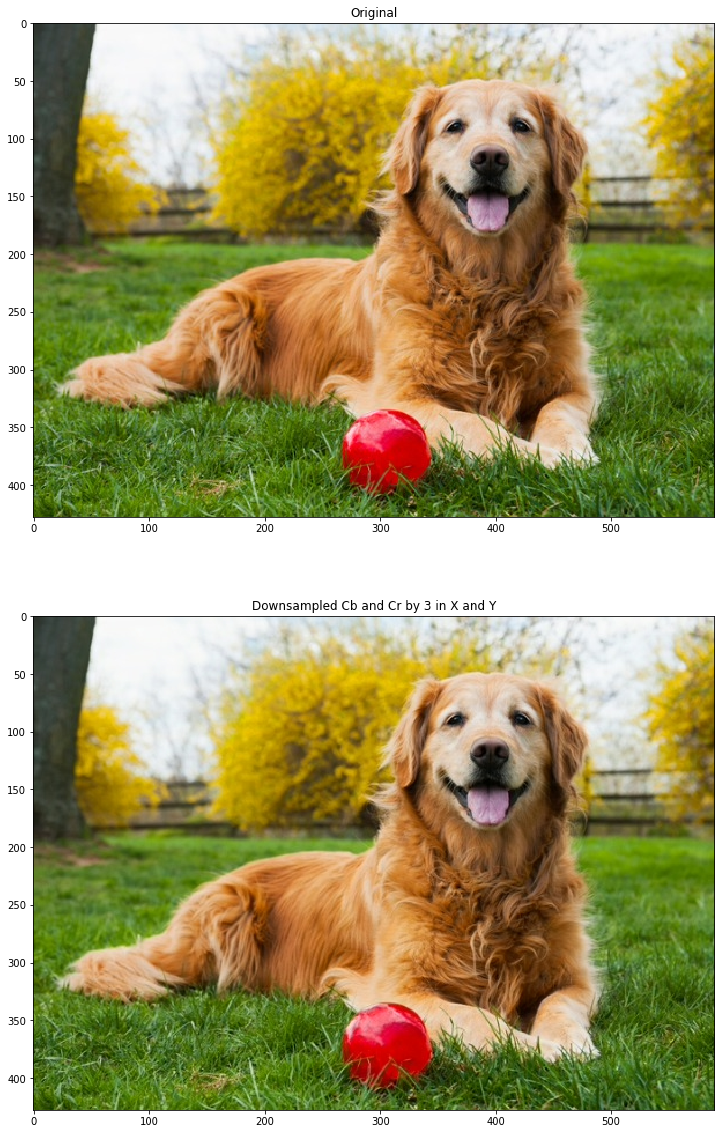

In [156]:
# The human eye is less sensitive to small changes in color hue than in color intensity.
# We can use this to our advantage by downsampling the luminance color shift
# information without much loss to image quality. This reduces image size.
# Perform downsampling via average pooling and strided convolution.

downsample_factor = 3
dim = downsample_factor
downsample_kernel = 1.0 / (dim**2) * np.ones((dim, dim))

def downsample(raw):
    blurred = signal.convolve2d(raw, downsample_kernel, mode='valid')
    downsampled = blurred[::downsample_factor, ::downsample_factor]
    return downsampled

cb_downsampled = downsample(cb)
cr_downsampled = downsample(cr)

# Plot before and after
plt.rcParams['figure.figsize'] = [40, 20]

cb_reconstruct = cv2.resize(cb_downsampled, dsize=(cb.shape[1], cb.shape[0]), interpolation=cv2.INTER_CUBIC)
cr_reconstruct = cv2.resize(cr_downsampled, dsize=(cr.shape[1], cr.shape[0]), interpolation=cv2.INTER_CUBIC)
compressed_img = np.stack((y, cr_reconstruct, cb_reconstruct), axis=-1)
compressed_img = np.array(compressed_img, dtype=np.uint8)
compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_YCrCb2RGB)

fig, ax = plt.subplots(2,1)
rgb = np.fliplr(raw_img.reshape(-1,3)).reshape(raw_img.shape)
ax[0].imshow(rgb)
ax[0].set_title('Original')
ax[1].imshow(compressed_img)
ax[1].set_title('Downsampled Cb and Cr by {} in X and Y'.format(downsample_factor))

### Discrete Cosine Transform

The next step in the typical JPEG compression scheme is to employ the discrete cosine transform. The high level strategy will be to represent this original image as a sum of basis functions scaled by coefficients. By moving from the pixel-space to the coefficient space, we can save a large order of magnitude in message size by only keeping the principle components of the image and discarding less important frequency information which is indistinguishable to the human eye.

The discrete cosine transform resembles its cousin, the discrete fourier transform, in that they both represent a finite length discrete space signal in terms of scaled and shifted basis functions. However, the DFT utilizes a class of complex exponential functions as its basis whereas the discrete cosine transform only uses real-valued cosine functions. The reason the DCT is more commonly used in image compression compared to the DFT is that the DCT often requires fewer series coefficients in order to approximate a typical function in a qualitative sense. Some would describe this phenomena as having more energy concentrated in a smaller number of coefficients than transforms like the DFT. An intuition for this property is that the DCT because of its choice of boundary condition decorrelates consecutive samples of the original signal, meaning that consecutive terms of an additive series will represent distinct pieces that can describe very orthogonal parts of the function. In terms of information theory, because these terms are less correlated, more information can be coded in fewer terms.

Below we plot a typical set of basis function used in JPEG compression. Each tile represents an 8x8 patch of pixels which have increasing spatial frequencies in the x and y directions. Each light white pixel can be viewed as a peak and each black pixel can be viewed as a trough of the cosine wave. 8x8 is a somewhat arbitary dimension (computer engineers tend to prefer numbers which are powers of two) that does a reasonable job for most images.

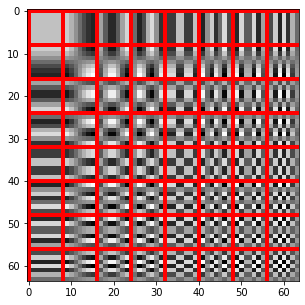

In [157]:
# Create and plot the different spatial frequencies used in the DCT
patch_dim = 8

# DCT of delta function in x and y
def dct_delta(x,y,u,v):
    alpha_u = 1.0 / np.sqrt(2.0) if u == 0 else 1.0
    alpha_v = 1.0 / np.sqrt(2.0) if v == 0 else 1.0
    cos_x = np.cos((2*x+1)*u*np.pi/16.0)
    cos_y = np.cos((2*y+1)*v*np.pi/16.0)
    return 0.25 * alpha_u * alpha_v * cos_x * cos_y

def plot_dct_basis():
    dct_img = np.zeros((patch_dim**2, patch_dim**2, 3))

    # Render DCT frequency cell by cell
    for u in range(patch_dim):
        for v in range(patch_dim):
            for x in range(patch_dim):
                for y in range(patch_dim):
                    dct_img[v*patch_dim+y, u*patch_dim+x] = dct_delta(x, y, u, v)

    # Normalize to uint8 range                
    std = 127.0 / dct_img.max()
    mean = 127.0
    dct_img = np.array((dct_img * std) + mean, dtype=np.uint8)

    # Paint red border for easier distinction of 8x8 frequency images
    for u in range(patch_dim):
        for v in range(patch_dim):
            for x in range(patch_dim):
                for y in range(patch_dim):
                    if x == 0 or y == 0:
                        dct_img[v*patch_dim+y, u*patch_dim+x, 0] = 255
                        dct_img[v*patch_dim+y, u*patch_dim+x, 1:] = 0

    plt.rcParams['figure.figsize'] = [10, 5]
    plt.imshow(dct_img)
    
    
plot_dct_basis()

### DCT of the Image

Now let us encode the image via the DCT coefficients.


Luminance
[[1963   -5    0   -2    0    0    0    0]
 [   7   -1   -4    0    0    0    0    0]
 [  -4    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]

Blue Shift
[[317 -28   6  -9   4  -3   0   0]
 [-18  -8   4  -2  -1  -5   0   0]
 [ -4  11  -2  -4   0   4   0   1]
 [ -6   0   6   0   2   1   0   0]
 [  4   0   8   2   1  -1   1   0]
 [ -1   5   0  -3  -2   0   0   0]
 [  2  -3  -2   0   1   0  -1   0]
 [ -1   1   0   1   0   0   0   0]]

Red Shift
[[1262    0   -6    0    0    1    1    0]
 [   3    2   -1    0    1    0    0    0]
 [   0   -4    1    0    1    0    0    0]
 [   1    0    0    0    0    0    0    0]
 [  -1   -1   -3    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0]
 [   0    0    1    0    0    0    0   

Text(0.5, 1.0, 'Original Luminance Channel')

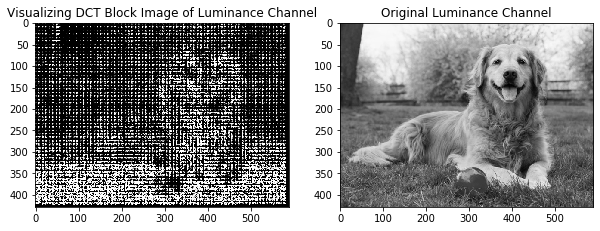

In [158]:
def dct2(inputimg):
    return scipy.fftpack.dct(scipy.fftpack.dct(inputimg, axis=0, norm='ortho'), axis=1, norm='ortho' )

# Encode each 8x8 patch in the image with a discrete cosine transform.
# Because human eyes are not as sensitive to high frequency color intensity
# change information, we can try to sparsify our representation of the image
# in the DCT domain by truncating certain frequency components without much
# noticable loss in image quality.
patch_dim = 8
channels = [y, cb_downsampled, cr_downsampled]
channels = [np.array(c, dtype=np.uint8) for c in channels]
channel_coeffs = [np.zeros_like(c, dtype=np.int16) for c in channels]
for c_i, channel in enumerate(channels):
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height - patch_dim, patch_dim)
    col_range = range(0, channel_width - patch_dim, patch_dim)
    patch_offsets = [(r,c) for r in row_range for c in col_range]
    for r_start, c_start in patch_offsets:
        r_end = r_start + patch_dim
        c_end = c_start + patch_dim
        patch = channel[r_start : r_end, c_start : c_end]
        
        dct_coeffs = dct2(patch)
        
        channel_coeffs[c_i][r_start : r_end, c_start : c_end] = dct_coeffs

# The result is a set of 64 DCT coefficients per 8x8 image patch. Coeff_ij corresponds to basis function_ij. 
# In order to save on space, we can convert our floating point coefficients
# into integer approximated coefficients using 16 bits per integer instead of 32 or 64 per float.
# This seems like a reasonable thing to do as long as we expect our coefficient to not exceed 
# the range of [-2^15, 2^15 - 1]. 8-bits would be cutting it way too short [-128, 127].
# If we print just a few image patches, we will notice not only
# is there great sparsity in these coefficient matrices but also that
# several high frequency components share very little contribution
# to the composition of the final image patch. These will be prime candidates
# to remove upon compression.

with np.printoptions(precision=3, suppress=True):
    i=5
    j=7
    loc = (slice(i*8, (i+1)*8, None), slice(j*8, (j+1)*8, None))
    print("\nLuminance")
    print(channel_coeffs[0][loc])
    print("\nBlue Shift")
    print(channel_coeffs[1][loc])
    print("\nRed Shift")
    print(channel_coeffs[2][loc])
    
# Plot the DCT blocks as an image, white represents high magnitude components.
# If you squint, you may see edges from the original image.
# This is because edge information represents high frequency color intensity changes
# meaning that DCT blocks will have more non-zero entries leading to larger 
# percentages of the boxes appear white in this visualization.
# We can see in the dog image that the background is more blurry than the foreground,
# and the DCT reflects this observation in number of non-trivial coefficients.
fig2, ax2 = plt.subplots(1,2)
abs_chan = np.abs(channel_coeffs[0])
ax2[0].imshow(abs_chan, cmap='gray', vmin=0, vmax=abs_chan.max()*0.005)
ax2[1].imshow(y, cmap='gray', vmin=0, vmax=255)
ax2[0].set_title("Visualizing DCT Block Image of Luminance Channel")
ax2[1].set_title("Original Luminance Channel")

### Quantization

Quantization refers to the truncating of certain frequency components in this basis in order to reduce the number of components required to represent the original image. JPEG compression tends to simply truncate by performing integer division into the DCT coefficients using something called a Quantization Table. A Quantization Table is a table of tuned integer values which tend to cut away just the right amount of an image's frequency representation to be very close to the original image in quality while deleting as many components as possible. In Photoshop, for example, Adobe engineers might create a variety of quantization tables for different user applications and quality tolerances. Designing these quantization tables to be tailored for the human eye is itself an interesting challenge as practically we would like a small number of tables to work well for a whole world of images with very different subjects and lighting conditions. This paper discusses the subject more thoroughly [https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=822921](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=822921).

Number of non-zero entries before:  120613
Number of non-zero entries after:  89756
74.42% of original coefficients left over


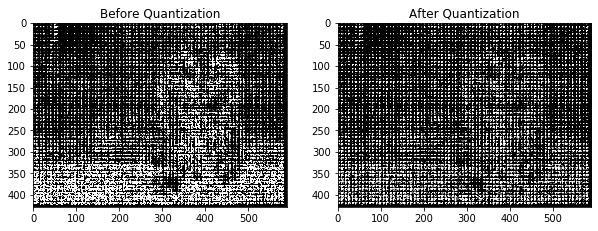

In [159]:
# Quantization tables from JPEG standard (https://web.stanford.edu/class/ee398a/handouts/lectures/08-JPEG.pdf)

Y_quant_table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 36, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
], dtype=np.int16)//4

Cb_quant_table = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
], dtype=np.int16)

Cr_quant_table = Cb_quant_table[:,:]


# Quantize channels
patch_dim = 8

def quantize(channel, qtable):
    output_channel = np.zeros_like(channel)
    
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height - patch_dim, patch_dim)
    col_range = range(0, channel_width - patch_dim, patch_dim)
    patch_offsets = [(r,c) for r in row_range for c in col_range]
    for r_start, c_start in patch_offsets:
        r_end = r_start + patch_dim
        c_end = c_start + patch_dim
        patch = channel[r_start : r_end, c_start : c_end]
        
        output_channel[r_start : r_end, c_start : c_end] = patch // qtable
        
    return output_channel
        
y_quant = quantize(channel_coeffs[0], Y_quant_table)
cb_quant = quantize(channel_coeffs[1], Cb_quant_table)
cr_quant = quantize(channel_coeffs[2], Cr_quant_table)

# Before and after quantization visualizations
fig3, ax3 = plt.subplots(1,2)
abs_chan = np.abs(channel_coeffs[0])
abs_chan_2 = np.abs(y_quant)
ax3[0].imshow(abs_chan, cmap='gray', vmin=0, vmax=abs_chan.max()*0.005)
ax3[1].imshow(abs_chan_2, cmap='gray', vmin=0, vmax=abs_chan_2.max()*0.005)
ax3[0].set_title("Before Quantization")
ax3[1].set_title("After Quantization")

nonzero_before = sum([np.count_nonzero(coeff) for coeff in channel_coeffs])
nonzero_after = sum([np.count_nonzero(coeff) for coeff in [y_quant, cb_quant, cr_quant]])

print("Number of non-zero entries before: ", nonzero_before)
print("Number of non-zero entries after: ", nonzero_after)
print("{:.2f}% of original coefficients left over".format(nonzero_after / nonzero_before * 100.0))

### Huffman Coding

While it is impressive that we have managed to reduce the number of coefficients by nearly 40%, it will do us no good if we must store each and every zero valued coefficient in our message. For this reason, standard JPEG compression schemes utilize a variable length encoding commonly referred to as Huffman Coding. The idea is to take advantage of the sparsity of the post-quantized DCT coefficients to compress the representation. This encoding is lossless because it does not corrupt any information of the original image whereas most operations up till now have been lossy and remove some raw information from the image.

A fixed length encoding would assign a bit signature to each of the letter of an alphabet and scan the message looking for exactly matching sequences. For example, the English alphabet consists of 26 lets, which means we would require at least 5 bits to encode 26 different letters (2^4 = 16 < 26 < 2^5 = 32). For our first few letters we might have:

00000: a

00001: b

00010: c

00011: d

00100: e
...
etc.

So if we wanted to write the word "baddeed", this would translate to 00001|00000|00011|00011|00100|00100|00011. This means the length of the message is 5*number of characters (35 bits in this case). While this code is easy to parse, we can do better. We can notice that there is some repetition in the prefix of these codes and that some symbols occur more frequently than others. Using this knowledge, we can construct a tree which reduces the parsing to a prefix lookup problem. The Huffman algorithm will do this for us automatically. For example, we might have word appearance probabilities for the string "baddeed" like:

a: $\frac{1}{7}$

b: $\frac{1}{7}$

c: $0$

d: $\frac{3}{7}$

e: $\frac{2}{7}$.

Thus we can construct a lookup tree that looks like this:

![huffmantree](huffman.jpg)

By parsing the message using this tree starting at the root and terminating each character at a leaf, we code the message "baddeed" as 101|100|0|0|11|11|0 which is only 13 bits long!

This variable length encoding is crutial to JPEG compression as many of the sparse entries will be squashed into a single bit of information as opposed to $log_2(N)$ bits. Many times, encoders also pull the trick of creating signifiers for long strings of zeros to reduce these to a smaller size even still. In order to pull this trick, it is also necessary to perform one last transformation to the coefficient matrices which is to scan through the pixels in a "zig-zag" fashion. This is because the DCT coefficient matrix will be sparser after quantization for higher frequency components, and so we want to encode long lines of zeros without running into any non-zero scalars. To do this, it is smart to scan in the zig-zag fashion so that most low frequency components are compacted right next to each other. The image below illustrates this technique:

![zigzag](zigzag.png)


In [160]:
patch_dim = 8

# Compute the zigzag transform
def zigzag(channel):
    output = {}
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height - patch_dim, patch_dim)
    col_range = range(0, channel_width - patch_dim, patch_dim)
    patch_offsets = [(r,c) for r in row_range for c in col_range]
    for r_start, c_start in patch_offsets:
        r_end = r_start + patch_dim
        c_end = c_start + patch_dim
        coords = [(y,x) for y in range(r_start, r_end) for x in range(c_start, c_end)]
        
        # Sort coordinates in zig-zag order
        # Primary sort index is sum(y,x) meaning we want successive diagonals of the matrix.
        # Secondary sort index (tie breaker) is ordered by column (x's). We apply a -1 factor
        # to the tie breaker depending on what diagonal we are looking at. If it is an even
        # index diagonal (mod 2 == 0), we will sort from left to right, otherwise right to left. 
        # This gives us the exact zigzag pattern as we see in the image above.
        coords = sorted(coords, key=lambda t: (sum(t), t[1]*(-1)**(sum(t) % 2)))
        
        # Now lookup the sorted coordinates in the quantized image and organize the data in a 
        # straight line.
        flat_matrix = [channel[y,x] for y,x in coords]
        
        # Remove all trailing zero coefficients for greater compactness
        flat_matrix = list(np.trim_zeros(flat_matrix, trim='b'))
        
        # Output results
        output[(r_start, c_start)] = flat_matrix
        
    return output

y_zz = zigzag(y_quant)
cb_zz = zigzag(cb_quant)
cr_zz = zigzag(cr_quant)

print("Y Channel Square Coefficient Matrix Example")
print(y_quant[8:16, 8:16])
print("")
print("Y Channel Flat Coefficient Matrix Example")
print(y_zz[(8,8)])

Y Channel Square Coefficient Matrix Example
[[130  -5  -4   0   0   0   0   0]
 [ -1  -2   1   0   0   0   0   0]
 [ -1   0   0   0   0   0   0   0]
 [ -2  -1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [ -1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

Y Channel Flat Coefficient Matrix Example
[130, -5, -1, -1, -2, -4, 0, 1, 0, -2, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1]


In [161]:
import huffman

# Need alphabet to construct huffman code
# Alphabet are the integer quantized DCT coeffs and their frequencies in the image
# Because there are many 0's in the DCT matrices, we should expect a short code
# for these once the huffman algorithm has generated its codebook.
def collect_alphabet(channel):
    counts = {}
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height)
    col_range = range(0, channel_width)
    coords = [(r,c) for r in row_range for c in col_range]
    for r, c in coords:
        if channel[r,c] not in counts:
            counts[channel[r,c]] = 0
        counts[channel[r,c]] += 1
    return counts

# Compute the Huffman Code
def huffman_code(channel, flat_channel):
    alphabet = collect_alphabet(channel)
    huff_code = huffman.codebook(alphabet.items())
    output = {}
    
    for pixel_loc, flat_mat in flat_channel.items():
        output[pixel_loc] = ''.join([huff_code[x] for x in flat_mat])
    
    return alphabet, huff_code, output
    
alphabet, y_huff_code, y_coded = huffman_code(y_quant, y_zz)
_, cb_huff_code, cb_coded = huffman_code(cb_quant, cb_zz)
_, cr_huff_code, cr_coded = huffman_code(cr_quant, cr_zz)

# Print some examples of the coded coefficients
examples = [0, 1, 2]
print("Coefficient frequencies in the image for", examples)
print(", ".join([str(x) + ": " + str(alphabet[x]) for x in examples]))
print("")
print("Calculated optimal Huffman Encodings for", examples)
print(", ".join([str(x) + ": '" + y_huff_code[x] + "'" for x in examples]))

Coefficient frequencies in the image for [0, 1, 2]
0: 177007, 1: 7907, 2: 4271

Calculated optimal Huffman Encodings for [0, 1, 2]
0: '1', 1: '0001', 2: '00110'


As we can see, coefficients with greater frequencies are assigned shorter codes, especially the value 0 which represents the sparse entries. It naturally holds the shortest code. Below we can see how much the Huffman code compressed its input.

In [162]:
# Compare the Huffman Coded size to the original input size
y_size = sum([len(m) for m in y_coded.values()])
cb_size = sum([len(m) for m in cb_coded.values()])
cr_size = sum([len(m) for m in cr_coded.values()])
huffman_msg_size = y_size + cb_size + cr_size
# Original message has w*h coefficient entries encoded by a fixed length 8 bit value
orig_msg_size = sum([8*np.prod(channel.shape) for channel in [y_quant, cb_quant, cr_quant]])
print("Number of bits in the original message: ", orig_msg_size)
print("Number of bits in the Huffman coded message: ", huffman_msg_size)
print("{:.2f}% of the original message size ".format(huffman_msg_size / orig_msg_size * 100))

Number of bits in the original message:  2465472
Number of bits in the Huffman coded message:  554869
22.51% of the original message size 


Wow, what a reduction! Let us compare to the original raw RGB image size to see how much space we have saved overall using JPEG style compression.

In [163]:
# Original RGB image
num_raw_entries = np.prod(raw_img.shape)
num_raw_bits = 8*num_raw_entries

# Comparison
print("Number of bits in the original RGB image: ", num_raw_bits)
print("Number of bits in the compressed JPEG: ", huffman_msg_size)
print("{:.2f}% of the original message size ".format(huffman_msg_size / num_raw_bits * 100))

Number of bits in the original RGB image:  6060480
Number of bits in the compressed JPEG:  554869
9.16% of the original message size 


**This is indeed a dramatic reduction in message size by an order of magnitude.** We must keep in mind that we would indeed need to also encode the Huffman tree and send it along the wire to the recipient, however it shall not take much space as it is a binary tree and grows at worst close to order $|X|$ where $X$ is the alphabet size space complexity and can be reused over the entire image. Since our 8 bit encoding must lie between $[0,255]$, this bounds the alphabet size to be much smaller than the information in our large images.

## Decoding

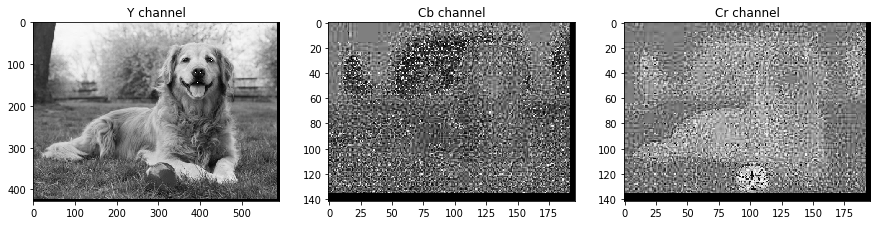

In [164]:
# Invert every operations so far to decode the message
# For simpliciy, we'll skip the huffman decoding step
# start from the coefficient matrix.

# Unquantize
def unquantize(channel, qtable):
    output_channel = np.zeros_like(channel)
    
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height - patch_dim, patch_dim)
    col_range = range(0, channel_width - patch_dim, patch_dim)
    patch_offsets = [(r,c) for r in row_range for c in col_range]
    for r_start, c_start in patch_offsets:
        r_end = r_start + patch_dim
        c_end = c_start + patch_dim
        patch = channel[r_start : r_end, c_start : c_end]
        
        output_channel[r_start : r_end, c_start : c_end] = patch * qtable
        
    return output_channel
        
y_unquant = unquantize(y_quant, Y_quant_table)
cb_unquant = unquantize(cb_quant, Cb_quant_table)
cr_unquant = unquantize(cr_quant, Cr_quant_table)

# Inverse DCT
def idct2(inputimg):
    return scipy.fftpack.idct(scipy.fftpack.idct(inputimg, axis=0 , norm='ortho'), axis=1 , norm='ortho')

patch_dim = 8
channels = [y_unquant, cb_unquant, cr_unquant]
channels = [np.array(c, dtype=np.int16) for c in channels]
channel_coeffs = [np.zeros_like(c, dtype=np.uint8) for c in channels]
for c_i, channel in enumerate(channels):
    channel_height, channel_width = channel.shape
    row_range = range(0, channel_height - patch_dim, patch_dim)
    col_range = range(0, channel_width - patch_dim, patch_dim)
    patch_offsets = [(r,c) for r in row_range for c in col_range]
    for r_start, c_start in patch_offsets:
        r_end = r_start + patch_dim
        c_end = c_start + patch_dim
        patch = channel[r_start : r_end, c_start : c_end]
        
        dct_coeffs = idct2(patch)
        
        channel_coeffs[c_i][r_start : r_end, c_start : c_end] = dct_coeffs
        
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax4 = plt.subplots(1,3)
titles = ["Y channel", "Cb channel", "Cr channel"]
for i in range(3):
    ax4[i].imshow(channel_coeffs[i], cmap='gray', vmin=0, vmax=255)
    ax4[i].set_title(titles[i])

Text(0.5, 1.0, 'Final Reconstructed Image')

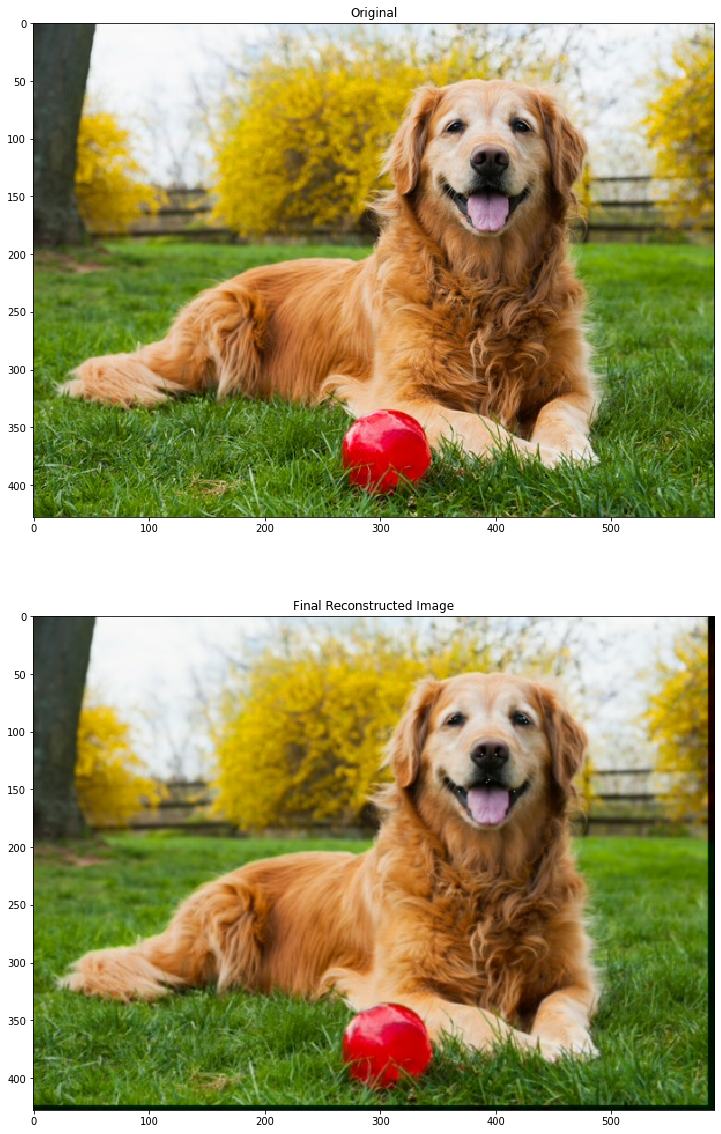

In [177]:
# Upsample chroma channels
y = channel_coeffs[0]
cb = channel_coeffs[1]
cr = channel_coeffs[2]

cb_reconstruct = cv2.resize(cb_downsampled, dsize=(y.shape[1], y.shape[0]), interpolation=cv2.INTER_CUBIC)
cr_reconstruct = cv2.resize(cr_downsampled, dsize=(y.shape[1], y.shape[0]), interpolation=cv2.INTER_CUBIC)

# Clean up some artifacts from IDCT
from scipy.ndimage.filters import gaussian_filter
y = gaussian_filter(y, sigma=0.6)

decompressed_img = np.stack((y, cr_reconstruct, cb_reconstruct), axis=-1)
decompressed_img = np.array(decompressed_img, dtype=np.uint8)
decompressed_img = cv2.cvtColor(decompressed_img, cv2.COLOR_YCrCb2RGB)

plt.rcParams['figure.figsize'] = [40, 20]
fig, ax5 = plt.subplots(2,1)
rgb = np.fliplr(raw_img.reshape(-1,3)).reshape(raw_img.shape)
ax5[0].imshow(rgb)
ax5[0].set_title('Original')
ax5[1].imshow(decompressed_img)
ax5[1].set_title('Final Reconstructed Image'.format(downsample_factor))

As we can see, the final image looks almost identical to the original which is 10 times larger in size. We do notice some artifacts on the border of the image and some specs on the dog's face. Therefore, this is some loss in quality, but one can argue that refinement of the quantization tables and post processing of the DCT can fix these problems. Overall, using a decomposition of the signal in the frequency domain and some other techniques, we were able to send a picture of a dog with a tenth of the size without much loss in quality.